In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
len(os.listdir('./data/SPE_carb10_58_box3/NLM'))

509

In [3]:
import imageio
import numpy as np
from tqdm import tqdm

In [4]:
import matplotlib.pyplot as plt

In [5]:
from stack_segmentation.stack import Stack

In [6]:
from sklearn.metrics import f1_score, average_precision_score, precision_score, recall_score

In [50]:
folder_path = './data/Urna_34/'

In [51]:
stack = Stack.read_from_source(folder_path)

700it [00:00, 930.36it/s]
100%|██████████| 700/700 [00:06<00:00, 102.89it/s]


In [52]:
test_stack = stack

In [53]:
q = test_stack.apply(runner, model, patch_sizes=(128, 128, 1))
q.measure(f1_score, threshold=0.5)

25200it [00:00, 255266.00it/s]
100%|██████████| 25200/25200 [00:07<00:00, 3456.93it/s]


0.992094608266276

In [54]:
q = test_stack.apply(runner, model, patch_sizes=(1, 128, 128))
q.measure(f1_score, threshold=0.5)

25200it [00:00, 49789.18it/s]
100%|██████████| 25200/25200 [00:01<00:00, 14976.31it/s]


0.9917943396327201

In [55]:
q = test_stack.apply(runner, model, patch_sizes=(128, 1, 128))
q.measure(f1_score, threshold=0.5)

25200it [00:00, 253441.99it/s]
100%|██████████| 25200/25200 [00:01<00:00, 13826.21it/s]


0.9917861691453652

In [48]:
values = []
for t in tqdm(np.linspace(0, 1, 21)):
    values.append(q.measure(f1_score, threshold=t))

 95%|█████████▌| 20/21 [29:03<01:27, 87.37s/it]/home/evlavrukhin/anaconda3/envs/py37_geo/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.

100%|██████████| 21/21 [30:23<00:00, 85.03s/it]


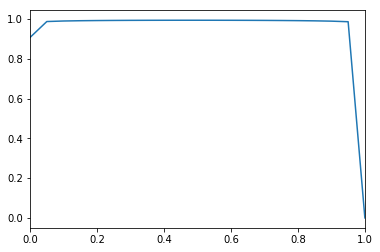

In [29]:
plt.plot(np.linspace(0, 1, 21), values)
plt.xlim([0, 1])
plt.show()

In [73]:
def _split_stack(stack, _slice, patch_sizes):
    return stack[_slice].slice_up(patch_sizes)

def _make_slice(axis, start, stop):
    _slice = [slice(None, None, None)] * 3
    _slice[axis] = slice(start, stop, 1)
    return tuple(_slice)
    
def train_val_test_stack_split(stack, 
                               patch_sizes=(128, 128, 1), 
                               axis=2,  train_size=2/3, val_size=1/6, test_size=1/6):
    train_data = [_split_stack(stack, _make_slice(axis, 
                                                  0, 
                                                  int(stack.D * train_size)), patch_sizes)
                  for stack in stacks]
    val_data = [_split_stack(stack, _make_slice(axis, 
                                                int(stack.D * train_size), 
                                                int(stack.D * (train_size + val_size))), patch_sizes)
                  for stack in stacks]
    test_data = [_split_stack(stack, _make_slice(axis, 
                                                 int(stack.D * (train_size + val_size)),
                                                 stack.D), patch_sizes)
                  for stack in stacks]
    return train_data, val_data, test_data

In [ ]:
def handle_stacks(stacks, axis=2, train_size=2/3, val_size=1/6, test_size=1/6, patch_sizes=(128, 128, 1)):
    train_data, val_data, test_data = train_val_test_stack_split(stacks, 
                                                                 patch_sizes, 
                                                                 axis, train_size, val_size, test_size)
    
    bs = 16
    num_workers = 16
    # patch_size = 256

    data_transform = transforms.Compose([
        Augmentor(
            dict_key="features",
            augment_fn=lambda x: \
                torch.from_numpy(x.copy().astype(np.float32) / 255.).unsqueeze_(0)),
        Augmentor(
            dict_key="features",
            augment_fn=transforms.Normalize(
                (0.5, ),
                (0.5, ))),
        Augmentor(
            dict_key="targets",
            augment_fn=lambda x: \
                torch.from_numpy(x.copy().astype(np.float32) / 255.).unsqueeze_(0))
    ])
    
    open_fn = lambda x: {'features': x['features'].squeeze(),
                     'targets': x['targets'].squeeze()}

    loaders = collections.OrderedDict()

    train_loader = UtilsFactory.create_loader(
        train_data, 
        open_fn=open_fn, 
        dict_transform=data_transform, 
        batch_size=bs, 
        num_workers=num_workers, 
        shuffle=True)

    valid_loader = UtilsFactory.create_loader(
        val_data, 
        open_fn=open_fn, 
        dict_transform=data_transform, 
        batch_size=bs, 
        num_workers=num_workers, 
        shuffle=False)

    loaders["train"] = train_loader
    loaders["valid"] = valid_loader
    
    from catalyst.contrib.models.segmentation import UNet
    import torch
    import torch.nn as nn
    from catalyst.dl.experiments import SupervisedRunner
    from datetime import datetime
    import catalyst
    from catalyst.dl.callbacks import EarlyStoppingCallback
    
    # experiment setup
    num_epochs = 50
    logdir = "./logs/segmentation_notebook_{}".format(str(datetime.now()))

    # model, criterion, optimizer
    model = UNet(num_classes=1, in_channels=1, num_filters=64, num_blocks=4)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15], gamma=0.3)


    # model runner
    runner = SupervisedRunner(device='cuda:1')
    # model training
    runner.train(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        loaders=loaders,
        callbacks=[EarlyStoppingCallback(patience=5)],
        logdir=logdir,
        num_epochs=num_epochs,
        verbose=True
    )

In [13]:
train_data = stack[:, :, :400].slice_up(patch_sizes=(128, 128, 1))
val_data = stack[:, :, 400:550].slice_up(patch_sizes=(128, 128, 1))
test_data = stack[:, :, 550:].slice_up(patch_sizes=(128, 128, 1))

14400it [00:00, 124163.77it/s]
5400it [00:00, 265508.96it/s]
5760it [00:00, 255986.00it/s]


In [ ]:
runner.infer()

In [14]:
# dataset_train = TomoDataset(X_train, Y_train)
# dataset_test = TomoDataset(X_test, Y_test)

In [15]:
import collections

import torchvision
import torchvision.transforms as transforms

from catalyst.data.augmentor import Augmentor
from catalyst.dl.utils import UtilsFactory

In [16]:
bs = 16
num_workers = 16
# patch_size = 256

data_transform = transforms.Compose([
    Augmentor(
        dict_key="features",
        augment_fn=lambda x: \
            torch.from_numpy(x.copy().astype(np.float32) / 255.).unsqueeze_(0)),
    Augmentor(
        dict_key="features",
        augment_fn=transforms.Normalize(
            (0.5, ),
            (0.5, ))),
    Augmentor(
        dict_key="targets",
        augment_fn=lambda x: \
            torch.from_numpy(x.copy().astype(np.float32) / 255.).unsqueeze_(0))
])

In [17]:
open_fn = lambda x: {'features': x['features'].squeeze(),
                     'targets': x['targets'].squeeze()}

loaders = collections.OrderedDict()

train_loader = UtilsFactory.create_loader(
    train_data, 
    open_fn=open_fn, 
    dict_transform=data_transform, 
    batch_size=bs, 
    num_workers=num_workers, 
    shuffle=True)

valid_loader = UtilsFactory.create_loader(
    val_data, 
    open_fn=open_fn, 
    dict_transform=data_transform, 
    batch_size=bs, 
    num_workers=num_workers, 
    shuffle=False)

loaders["train"] = train_loader
loaders["valid"] = valid_loader

In [18]:
from catalyst.contrib.models.segmentation import UNet

In [19]:
import torch
import torch.nn as nn
from catalyst.dl.experiments import SupervisedRunner

In [20]:
from datetime import datetime

In [30]:
import catalyst

In [31]:
from catalyst.dl.callbacks import EarlyStoppingCallback

In [40]:
# experiment setup
num_epochs = 50
logdir = "./logs/segmentation_notebook_{}".format(str(datetime.now()))

# model, criterion, optimizer
model = UNet(num_classes=1, in_channels=1, num_filters=64, num_blocks=4)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15], gamma=0.3)


# model runner
runner = SupervisedRunner(device='cuda:1')

In [41]:
# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    callbacks=[EarlyStoppingCallback(patience=5)],
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True
)

0/50 * Epoch (train): 100% 900/900 [01:43<00:00,  8.77it/s, _timers/_fps=212.263, loss=0.024]
0/50 * Epoch (valid): 100% 338/338 [00:14<00:00, 23.18it/s, _timers/_fps=6749.358, loss=0.023]
[2019-06-05 15:35:21,536] 
0/50 * Epoch 0 (train): _base/lr=0.0001 | _base/momentum=0.9000 | _timers/_fps=214.9745 | _timers/batch_time=0.0768 | _timers/data_time=0.0741 | _timers/model_time=0.0027 | loss=0.0619
0/50 * Epoch 0 (valid): _base/lr=0.0001 | _base/momentum=0.9000 | _timers/_fps=4545.6962 | _timers/batch_time=0.0107 | _timers/data_time=0.0079 | _timers/model_time=0.0028 | loss=0.0239
1/50 * Epoch (train): 100% 900/900 [01:44<00:00,  8.74it/s, _timers/_fps=215.545, loss=0.023]
1/50 * Epoch (valid): 100% 338/338 [00:14<00:00, 23.35it/s, _timers/_fps=5373.438, loss=0.022]
[2019-06-05 15:37:21,523] 
1/50 * Epoch 1 (train): _base/lr=0.0001 | _base/momentum=0.9000 | _timers/_fps=212.1835 | _timers/batch_time=0.0778 | _timers/data_time=0.0750 | _timers/model_time=0.0027 | loss=0.0226
1/50 * Epoch

14/50 * Epoch (train): 100% 900/900 [01:45<00:00,  8.70it/s, _timers/_fps=211.887, loss=0.018]
14/50 * Epoch (valid): 100% 338/338 [00:15<00:00, 22.45it/s, _timers/_fps=5985.984, loss=0.018]
[2019-06-05 16:03:38,542] 
14/50 * Epoch 14 (train): _base/lr=0.0001 | _base/momentum=0.9000 | _timers/_fps=216.2660 | _timers/batch_time=0.0764 | _timers/data_time=0.0734 | _timers/model_time=0.0030 | loss=0.0181
14/50 * Epoch 14 (valid): _base/lr=0.0001 | _base/momentum=0.9000 | _timers/_fps=4524.7704 | _timers/batch_time=0.0108 | _timers/data_time=0.0080 | _timers/model_time=0.0027 | loss=0.0181
15/50 * Epoch (train): 100% 900/900 [01:45<00:00,  8.68it/s, _timers/_fps=210.404, loss=0.019]
15/50 * Epoch (valid): 100% 338/338 [00:14<00:00, 23.64it/s, _timers/_fps=6885.079, loss=0.018]
[2019-06-05 16:05:39,242] 
15/50 * Epoch 15 (train): _base/lr=0.0001 | _base/momentum=0.9000 | _timers/_fps=211.4736 | _timers/batch_time=0.0782 | _timers/data_time=0.0753 | _timers/model_time=0.0029 | loss=0.0179
15